# Task
1. Prediksi Jumlah penjualan (Qty) dari total keseluruhan produk Kalbe Nutritionals
2. Membuat Cluster Segment customer berdasarkan Kriteria

# 0. Import Library

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

# 1. Memanggil Data Frame

In [42]:
customer_df = pd.read_csv('datasets/Case Study - Customer.csv',sep=';')
product_df = pd.read_csv('datasets/Case Study - Product.csv',sep=';')
store_df = pd.read_csv('datasets/Case Study - Store.csv',sep=';')
transaction_df = pd.read_csv('datasets/Case Study - Transaction.csv',sep=';')

In [43]:
print(f'Panjang Customer: {len(customer_df)}')
print(f'Panjang Product: {len(product_df)}')
print(f'Panjang Store: {len(store_df)}')
print(f'Panjang transaksi: {len(transaction_df)}')

Panjang Customer: 447
Panjang Product: 10
Panjang Store: 14
Panjang transaksi: 5020


In [44]:
transaction_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [45]:
df = transaction_df.merge(customer_df).merge(product_df).merge(store_df)

In [46]:
df['Marital Status'].value_counts()

Marital Status
Married    3779
Single     1197
Name: count, dtype: int64

In [47]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [48]:
MaritalStat_Dummies = pd.get_dummies(df['Marital Status'],drop_first=True)
ProcuctName_Dummies = pd.get_dummies(df['Product Name'],drop_first=True)
StoreName_Dummies = pd.get_dummies(df['StoreName'],drop_first=True)
GroupStore_Dummies = pd.get_dummies(df['GroupStore'],drop_first=True)
Type_Dummies = pd.get_dummies(df['Type'],drop_first=True)

df = df.drop(['Marital Status', 'Product Name', 'StoreName', 'GroupStore','Type'], axis=1)

df = pd.concat([df, MaritalStat_Dummies,ProcuctName_Dummies,StoreName_Dummies,GroupStore_Dummies,Type_Dummies], axis=1)

In [49]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,...,Prima Kota,Prima Tendean,Sinar Harapan,Gita,Harapan Baru,Lingga,Prestasi,Priangan,Prima,Modern Trade
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,...,False,False,False,False,False,False,True,False,False,False
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,...,False,False,False,False,False,False,True,False,False,False
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,...,False,False,False,False,False,False,True,False,False,False
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,...,False,False,False,False,False,False,True,False,False,False
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,...,False,False,False,False,False,False,True,False,False,False


In [50]:
df.isnull().sum()/len(df)*100

TransactionID       0.0
CustomerID          0.0
Date                0.0
ProductID           0.0
Price               0.0
Qty                 0.0
TotalAmount         0.0
StoreID             0.0
Age                 0.0
Gender              0.0
Income              0.0
Latitude            0.0
Longitude           0.0
Single              0.0
Cheese Stick        0.0
Choco Bar           0.0
Coffee Candy        0.0
Crackers            0.0
Ginger Candy        0.0
Oat                 0.0
Potato Chip         0.0
Thai Tea            0.0
Yoghurt             0.0
Buana               0.0
Buana Indah         0.0
Gita Ginara         0.0
Harapan Baru        0.0
Lingga              0.0
Prestasi Utama      0.0
Priangan            0.0
Prima Kelapa Dua    0.0
Prima Kota          0.0
Prima Tendean       0.0
Sinar Harapan       0.0
Gita                0.0
Harapan Baru        0.0
Lingga              0.0
Prestasi            0.0
Priangan            0.0
Prima               0.0
Modern Trade        0.0
dtype: float64

Terdapat 44 null atau setara dengan 0.875% nilai null pada kolom Marital Status
Nilai tersebut sangat sedikit (<1%) sehingga dapat langsung dihilangkan

In [51]:
df.dropna(inplace=True)

In [52]:
df.isnull().sum()/len(df)*100

TransactionID       0.0
CustomerID          0.0
Date                0.0
ProductID           0.0
Price               0.0
Qty                 0.0
TotalAmount         0.0
StoreID             0.0
Age                 0.0
Gender              0.0
Income              0.0
Latitude            0.0
Longitude           0.0
Single              0.0
Cheese Stick        0.0
Choco Bar           0.0
Coffee Candy        0.0
Crackers            0.0
Ginger Candy        0.0
Oat                 0.0
Potato Chip         0.0
Thai Tea            0.0
Yoghurt             0.0
Buana               0.0
Buana Indah         0.0
Gita Ginara         0.0
Harapan Baru        0.0
Lingga              0.0
Prestasi Utama      0.0
Priangan            0.0
Prima Kelapa Dua    0.0
Prima Kota          0.0
Prima Tendean       0.0
Sinar Harapan       0.0
Gita                0.0
Harapan Baru        0.0
Lingga              0.0
Prestasi            0.0
Priangan            0.0
Prima               0.0
Modern Trade        0.0
dtype: float64

# 2.Modelling
## 1. Qty Forecasting using ARIMA

In [53]:
df['Date'] = pd.to_datetime(df['Date'],format='mixed')

In [54]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,...,Prima Kota,Prima Tendean,Sinar Harapan,Gita,Harapan Baru,Lingga,Prestasi,Priangan,Prima,Modern Trade
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,...,False,False,False,False,False,False,True,False,False,False
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,...,False,False,False,False,False,False,True,False,False,False
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,...,False,False,False,False,False,False,True,False,False,False
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,...,False,False,False,False,False,False,True,False,False,False
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,...,False,False,False,False,False,False,True,False,False,False


In [55]:
# model regresi: time series
df_regresi = df.groupby('Date').agg({'Qty':'sum'})
df_regresi.head()

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


Text(0, 0.5, 'Qty')

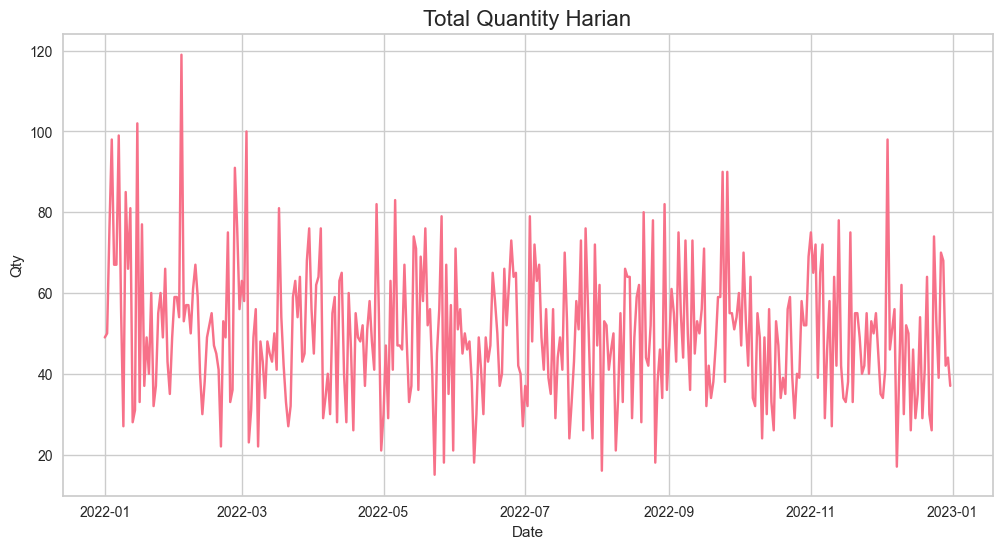

In [56]:
custom_palette = sns.color_palette("husl")

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', data=df_regresi, color=custom_palette[0])
plt.title('Total Quantity Harian', fontsize=16)  
plt.xlabel('Date')  
plt.ylabel('Qty') 

#### Splitting Data

In [57]:
#Karena ini kasus time series, akan dibagi data secara berurutan sebanyak 20% sebagai data test
train_size = int(len(df_regresi) * 0.8)  
train_data, test_data = df_regresi.iloc[:train_size], df_regresi.iloc[train_size:]

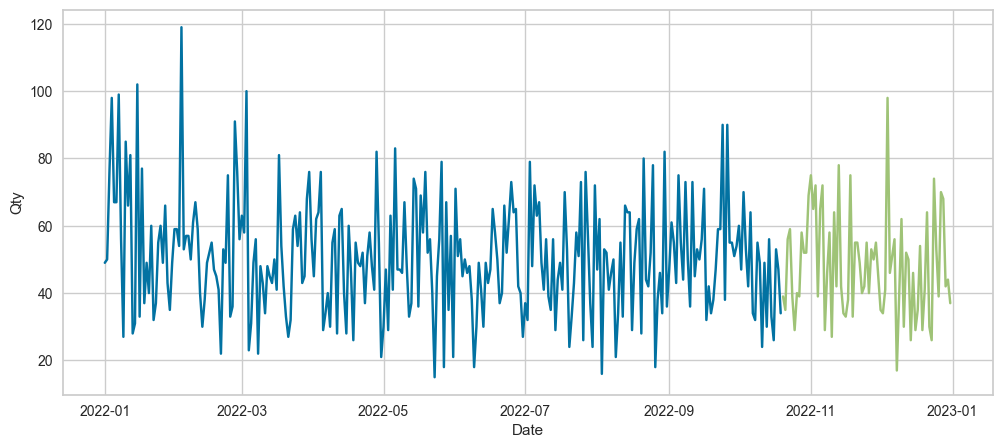

In [58]:
plt.figure(figsize=(12,5))
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Qty'])
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Qty'])
plt.show()

#### Uji Stasioner

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_regresi['Qty'])

print(f'ADF Statistic: {result[0]}')
print(f'p-Value: {result[1]}')
print('Critical Values:')

for key,Value in result[4].items():
    print(f'{key}:{Value}')

ADF Statistic: -19.01878280229973
p-Value: 0.0
Critical Values:
1%:-3.4484434475193777
5%:-2.869513170510808
10%:-2.571017574266393


#### Modelling ARIMA

In [60]:
# Evaluation
def rmse(y_actual, y_pred):
    print(f'RMSE Value: {mean_squared_error(y_actual, y_pred)**0.5}')
def eval(y_actual, y_pred):
    rmse(y_actual, y_pred)
    print(f'MAE Value: {mean_absolute_error(y_actual, y_pred)}')

RMSE Value: 15.47240044185915
MAE Value: 12.35707965758799


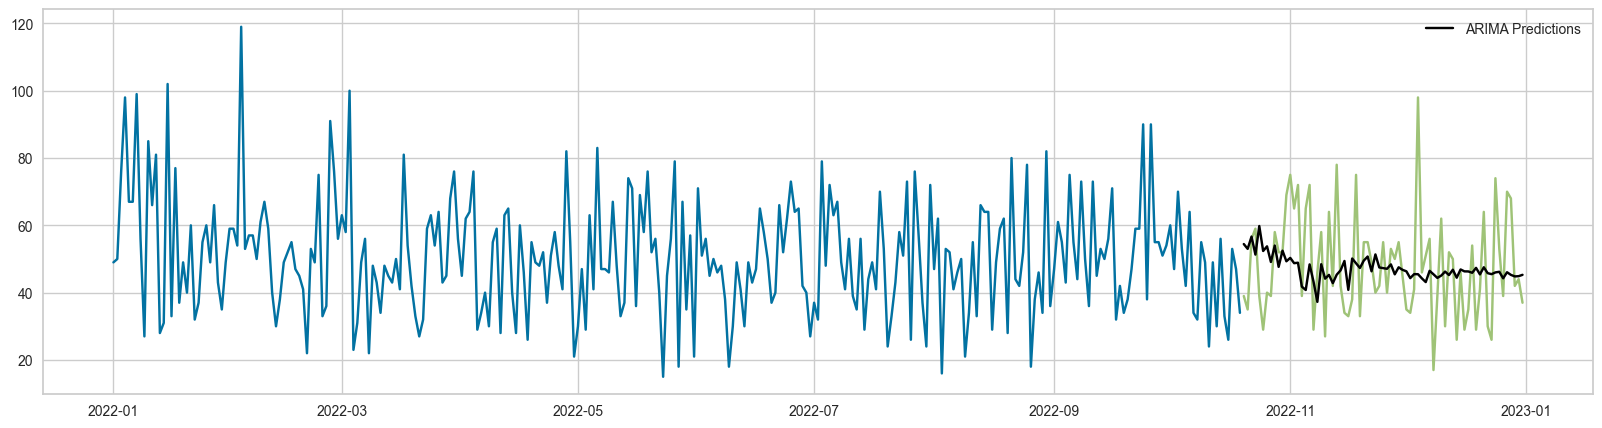

In [61]:
y = train_data['Qty']

ARIMAmodel = ARIMA(y, order = (40,2,1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test_data))

y_pred_df = y_pred.conf_int()
y_pred_df['prediction'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test_data.index
y_pred_out = y_pred_df['prediction']
eval(test_data['Qty'], y_pred_out)


#Plotting Prediction
plt.figure(figsize=[20,5])
plt.plot(train_data['Qty'])
plt.plot(test_data['Qty'])
plt.plot(y_pred_out, color='black', label= 'ARIMA Predictions')
plt.legend()


In [18]:
from statsmodels.tsa.stattools import kpss

# Melakukan uji KPSS pada data time series
kpss_test = kpss(df_regresi['Qty'], regression='c')  # 'c' untuk model dengan komponen konstan (tren)

# Menampilkan hasil uji KPSS
print("Hasil Uji KPSS:")
print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Tingkat Signifikansi:", kpss_test[3])

# Mengevaluasi hasil uji KPSS
alpha = 0.05  # Tingkat signifikansi yang Anda tentukan (biasanya 0.05)
if kpss_test[1] < alpha:
    print("Kesimpulan: Data memiliki komponen tren (tidak stasioner)")
else:
    print("Kesimpulan: Data adalah stasioner")

Hasil Uji KPSS:
KPSS Statistic: 0.38019962318653766
p-value: 0.08568981759200962
Tingkat Signifikansi: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Kesimpulan: Data adalah stasioner


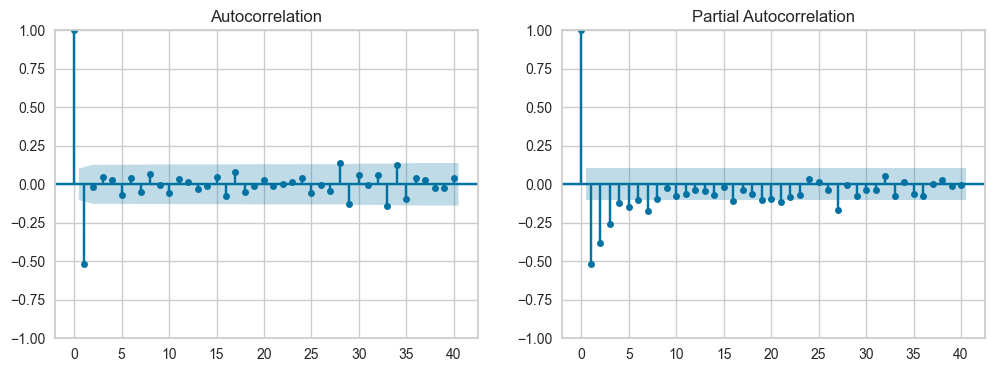

In [19]:
# ACF and PACF plots to determine p and q values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_regresi.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_regresi.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [20]:
import pmdarima as pm

#auto-fit ARIMA
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [21]:
from itertools import product
# Membuat list untuk p, d, dan q
p = range(0, 6)  # 0-5
d = range(0, 6)  # 0-5
q = range(0, 6)  # 0-5
# Menggunakan fungsi product dari itertools untuk membuat kombinasi p, d, dan q
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 3, 5), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 5, 0), (1, 5, 1), (1, 5, 2), (1, 5, 3), (1, 5, 4), (1, 5, 5), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 3, 0)

In [29]:
from statsmodels.tsa.arima.model import ARIMA
# Membuat list untuk menyimpan Skor AIC
aic_scores = []
# Melakukan grid search manual untuk menemukan p, d, q yang optimal
for param in pdq:
    # Melakukan fitting ARIMA model
    model = ARIMA(df_regresi, order=param)
    model_fit = model.fit()
    # Menambahkan aic score ke list
    aic_scores.append({'par': param, 'aic': model_fit.aic})
    
# Memilih aic score terkecil
best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (0, 5, 5), 'aic': 1732.407320086871}


In [38]:
#Hyperparameter tuning
model_hyper = ARIMA(train_data, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

Manual

In [24]:
#Trial and error tuning 
model_manual1 = ARIMA(train_data, order=(40,1,1))
model_fit_manual1 = model_manual1.fit()

In [25]:
#Trial and error tuning 
model_manual2 = ARIMA(train_data, order=(40,1,2))
model_fit_manual2 = model_manual2.fit()

In [26]:
#Trial and error tuning 
model_manual3 = ARIMA(train_data, order=(40,2,1))
model_fit_manual3 = model_manual3.fit()

In [27]:
#Trial and error tuning 
model_manual4 = ARIMA(train_data, order=(40,2,2))
model_fit_manual4 = model_manual4.fit()

Plot

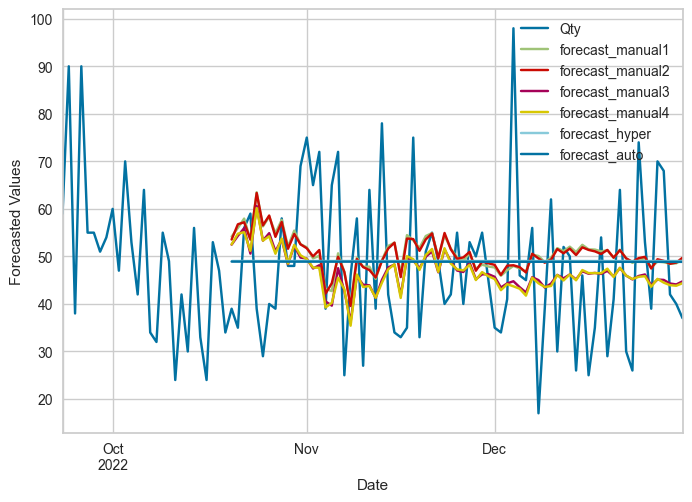

In [31]:
#plot forecasting
forecast_manual1 = model_fit_manual1.forecast(len(test_data))
forecast_manual2 = model_fit_manual2.forecast(len(test_data))
forecast_manual3 = model_fit_manual3.forecast(len(test_data))
forecast_manual4 = model_fit_manual4.forecast(len(test_data))
forecast_hyper = model_fit_hyper.forecast(len(test_data))
forecast_auto = auto_arima.predict(len(test_data))

df_plot = df_regresi.iloc[-100:]

df_plot['forecast_manual1'] = [None]*(len(df_plot)-len(forecast_manual1)) + list(forecast_manual1)
df_plot['forecast_manual2'] = [None]*(len(df_plot)-len(forecast_manual2)) + list(forecast_manual2)
df_plot['forecast_manual3'] = [None]*(len(df_plot)-len(forecast_manual3)) + list(forecast_manual3)
df_plot['forecast_manual4'] = [None]*(len(df_plot)-len(forecast_manual4)) + list(forecast_manual4)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_hyper)) + list(forecast_hyper)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.legend()

plt.show()

Metrics Evaluation

In [39]:
#Manual parameter tuning metrics

mae1 = mean_absolute_error(test_data, forecast_manual1)
mape1 = mean_absolute_percentage_error(test_data, forecast_manual1)
rmse1 = np.sqrt(mean_squared_error(test_data, forecast_manual1))

print(f'mae - manual: {round(mae1,4)}')
print(f'mape - manual: {round(mape1,4)}')
print(f'rmse - manual: {round(rmse1,4)}')

mae - manual: 13.2919
mape - manual: 0.3319
rmse - manual: 16.3091


In [33]:
mae2 = mean_absolute_error(test_data, forecast_manual2)
mape2 = mean_absolute_percentage_error(test_data, forecast_manual2)
rmse2 = np.sqrt(mean_squared_error(test_data, forecast_manual2))

print(f'mae - manual: {round(mae2,4)}')
print(f'mape - manual: {round(mape2,4)}')
print(f'rmse - manual: {round(rmse2,4)}')

mae - manual: 13.2087
mape - manual: 0.3299
rmse - manual: 16.2076


In [34]:
mae3 = mean_absolute_error(test_data, forecast_manual3)
mape3 = mean_absolute_percentage_error(test_data, forecast_manual3)
rmse3 = np.sqrt(mean_squared_error(test_data, forecast_manual3))

print(f'mae - manual: {round(mae3,4)}')
print(f'mape - manual: {round(mape3,4)}')
print(f'rmse - manual: {round(rmse3,4)}')

mae - manual: 12.6256
mape - manual: 0.294
rmse - manual: 15.8567


In [35]:
mae4 = mean_absolute_error(test_data, forecast_manual4)
mape4 = mean_absolute_percentage_error(test_data, forecast_manual4)
rmse4 = np.sqrt(mean_squared_error(test_data, forecast_manual4))

print(f'mae - manual: {round(mae4,4)}')
print(f'mape - manual: {round(mape4,4)}')
print(f'rmse - manual: {round(rmse4,4)}')

mae - manual: 12.6164
mape - manual: 0.2928
rmse - manual: 15.9346


In [36]:
#Hyperparameter tuning metrics

mae = mean_absolute_error(test_data, forecast_hyper)
mape = mean_absolute_percentage_error(test_data, forecast_hyper)
rmse = np.sqrt(mean_squared_error(test_data, forecast_hyper))

print(f'mae - hyper: {round(mae,4)}')
print(f'mape - hyper: {round(mape,4)}')
print(f'rmse - hyper: {round(rmse,4)}')

mae - hyper: 12.7851
mape - hyper: 0.3121
rmse - hyper: 15.5394


In [37]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(test_data, forecast_auto)
mape = mean_absolute_percentage_error(test_data, forecast_auto)
rmse = np.sqrt(mean_squared_error(test_data, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 12.7764
mape - auto: 0.3116
rmse - auto: 15.5332


Manual HyperParameter Tuning dengan urutan (40,2,2) menunjukan nilai evaluasi terbaik,
- mae - manual: 12.6164
- mape - manual: 0.2928
- rmse - manual: 15.9346

### Forecast Quantity

In [40]:
#Apply model to forecast data
model = ARIMA(df_regresi, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [41]:
# Assuming 'forecast' contains your forecasted values
forecast_df = pd.DataFrame({'Forecast Qty': forecast})

# Optionally, you can set the index to represent the dates for the forecasted period if applicable.
# For example, if you want to set the index starting from the next day after your existing data:
forecast_start_date = df_regresi.index[-1] + pd.DateOffset(days=1)
forecast_dates = pd.date_range(forecast_start_date, periods=len(forecast), freq='D')
forecast_df.index = forecast_dates

# Print the DataFrame
forecast_df.head()

,Forecast Qty
2023-01-01,55.525413
2023-01-02,45.366712
2023-01-03,46.601331
2023-01-04,51.822138
2023-01-05,43.808889


In [42]:
# Forecast
forecast_steps = 31  # Adjust as needed
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get lower and upper confidence intervals
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecasted values, lower, and upper bounds
forecast_df = pd.DataFrame({
    'Forecast Qty': forecast.predicted_mean.round(4),  # Round to 4 decimal places
    'Lower Qty': forecast_ci['lower Qty'].round(4), 
    'Upper Qty': forecast_ci['upper Qty'].round(4), 
})

# Optionally, set the index to represent the dates for the forecasted period if applicable.
# For example, if you want to set the index starting from the next day after your existing data:
forecast_start_date = df_regresi.index[-1] + pd.DateOffset(days=1)
forecast_dates = pd.date_range(forecast_start_date, periods=forecast_steps, freq='D')
forecast_df.index = forecast_dates

# Print the DataFrame
forecast_df.head(31)

,Forecast Qty,Lower Qty,Upper Qty
2023-01-01,55.5254,24.3113,86.7396
2023-01-02,45.3667,14.1518,76.5816
2023-01-03,46.6013,15.3615,77.8412
2023-01-04,51.8221,20.3630,83.2813
2023-01-05,43.8089,12.2458,75.3720
2023-01-06,34.0543,2.4910,65.6176
2023-01-07,44.3212,12.7542,75.8881
2023-01-08,36.8008,5.2259,68.3758
2023-01-09,42.9037,11.2085,74.5989
2023-01-10,52.4923,20.7945,84.1902


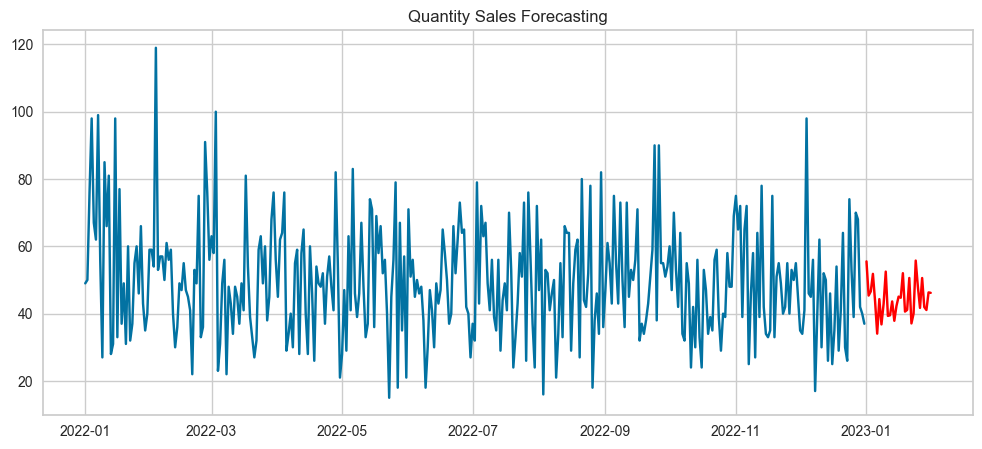

In [43]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_regresi)
plt.plot(forecast_df['Forecast Qty'],color='red')
plt.title('Quantity Sales Forecasting')
plt.show()

In [44]:
forecast_df.describe()

,Forecast Qty,Lower Qty,Upper Qty
count,31.000000,31.000000,31.000000
mean,44.489935,12.538484,76.441394
std,5.541914,5.558034,5.574847
min,34.054300,2.491000,65.617600
25%,40.846600,8.398250,72.735900
50%,43.808900,12.245800,75.376500
75%,47.330900,15.472250,79.974050
max,55.769500,24.311300,88.138800


Berdasarkan prediksi jumlah penjualan harian, rata-rata penjualan dibulan Januari 2023 adalah 44,49 atau sekitar 45 pcs/hari.

## Clustering Customer Using KMeans

In [45]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [47]:
df_clus = df.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_clus

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


In [48]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     444 non-null    int64
 1   TransactionID  444 non-null    int64
 2   Qty            444 non-null    int64
 3   TotalAmount    444 non-null    int64
dtypes: int64(4)
memory usage: 14.0 KB


In [49]:
df_cluster = df_clus.drop(columns = ['CustomerID'])
df_cluster.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


### PreProcessing

In [51]:
#Standarisasi dataset
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)

In [52]:
#Normalisasi dataset dengan minmaxscaler
X_norm = MinMaxScaler().fit_transform(X)

### Modeling

In [54]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1332.0000000000002, 543.4711248616254, 316.5534498820666, 237.6926072959066, 191.11956602309152, 169.35451312292088, 153.47776505365619, 141.0506163543352, 130.3072048875897, 121.28772073867492]


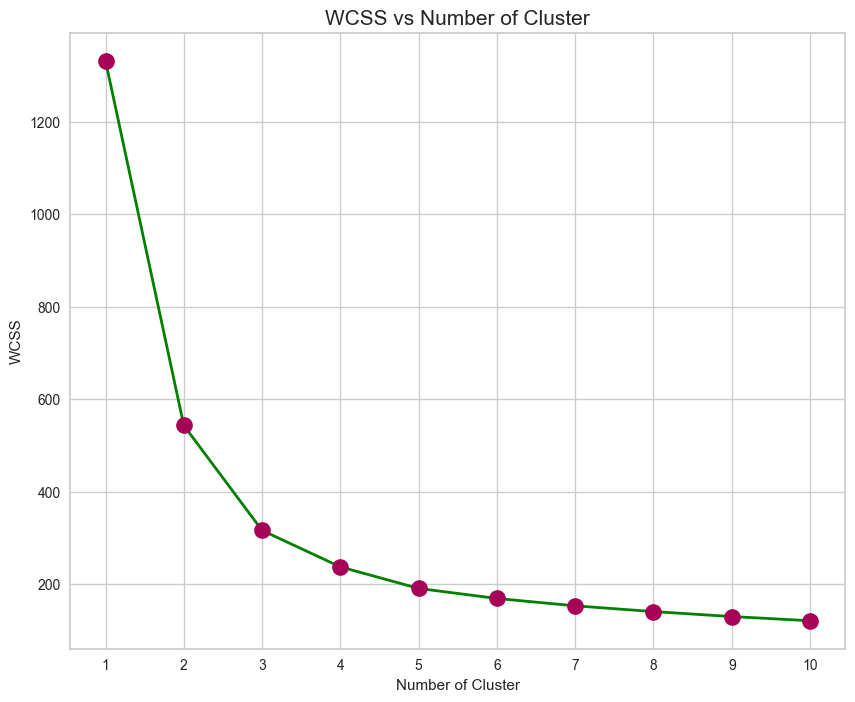

In [55]:
plt.figure(figsize=(10,8))
plt.plot(list(range(1,11)), wcss, color = 'green', marker = 'o', linewidth=2, markersize=12, markerfacecolor= 'm', 
         markeredgecolor= 'm')
plt.title('WCSS vs Number of Cluster', fontsize = 15)
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

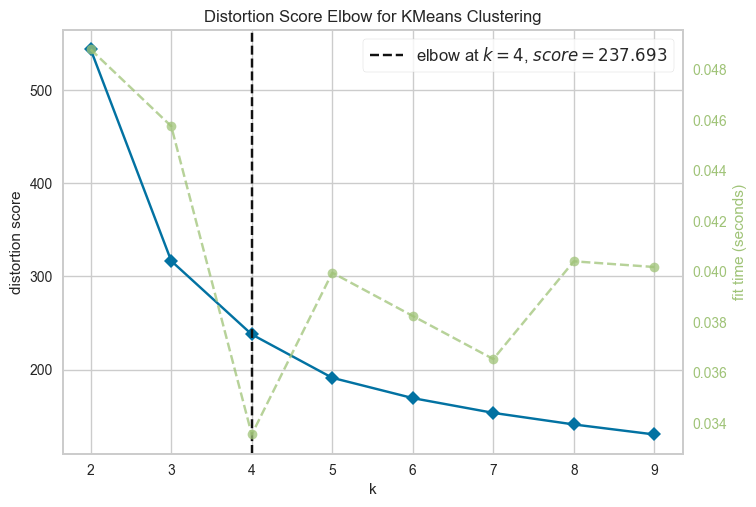

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [57]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

<Axes: >

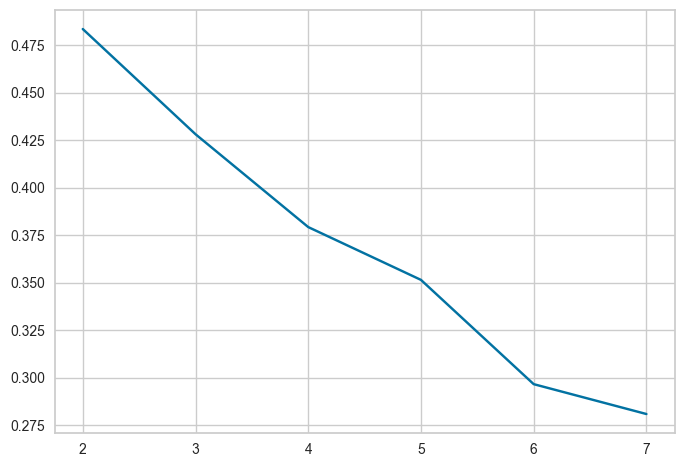

In [58]:
sns.lineplot(x = K, y = score)

Akan dipilih Cluster terbaik yaitu 4

In [59]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [60]:
# input cluster ke dataset
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,2
1,13,57,392300,0
2,15,56,446200,0
3,10,46,302500,3
4,7,27,268600,1


In [61]:
df_cluster['cluster'].value_counts()

cluster
3    180
0    115
1     93
2     56
Name: count, dtype: int64

<Figure size 600x600 with 0 Axes>

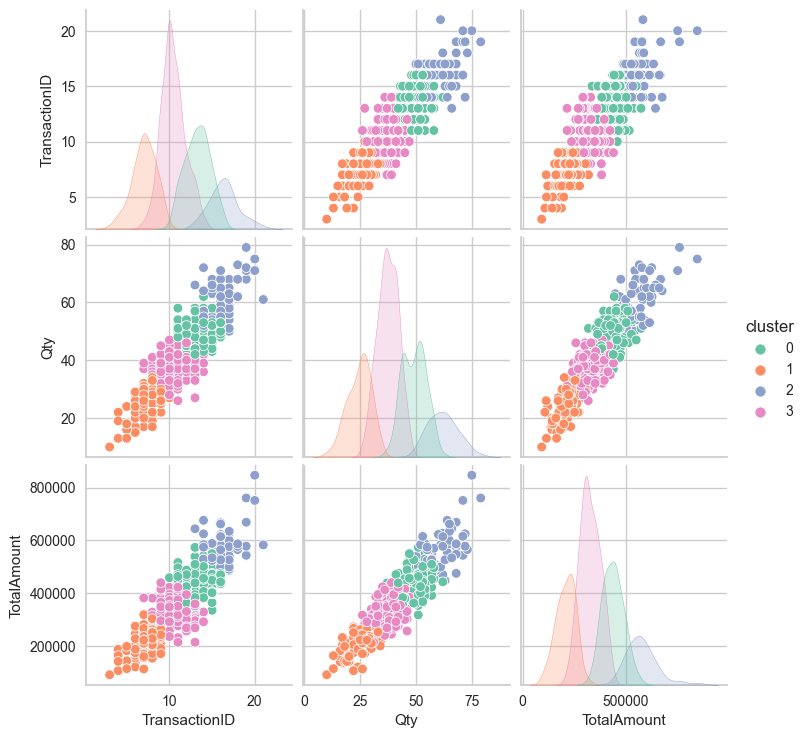

In [62]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set2')
plt.show()

### Customer Personality Analysis

In [63]:
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.groupby('cluster').agg(['count','mean', 'median', 'std'])

TransactionID                               Qty                    \
                count       mean median       std count       mean median   
cluster                                                                     
0                 115  13.286957   13.0  1.437378   115  49.121739   50.0   
1                  93   7.021505    7.0  1.398590    93  24.505376   25.0   
2                  56  16.392857   16.0  1.702176    56  62.035714   62.0   
3                 180  10.427778   10.0  1.382373   180  37.350000   37.0   

                  TotalAmount                                         
              std       count           mean    median           std  
cluster                                                               
0        5.189645         115  437241.739130  439300.0  50547.941431  
1        5.201638          93  208283.870968  211000.0  46253.056986  
2        6.525375          56  576716.071429  572600.0  74066.505193  
3        4.587419         180  325663.333333  319700.0  48411.042533

In [64]:
df_cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,444.0,11.207207,3.242960,3.0,9.0,11.0,13.0,21.0
Qty,444.0,40.822072,12.723926,10.0,32.0,40.0,50.0,79.0
TotalAmount,444.0,361641.216216,124596.157539,92100.0,270675.0,353200.0,439750.0,846700.0
cluster,444.0,1.677928,1.245256,0.0,0.0,2.0,3.0,3.0


In [65]:
# percentage of customers per cluster
cluster_count = df_cluster['cluster'].value_counts().reset_index()
cluster_count.columns = ['cluster', 'count']
cluster_count['percentage (%)'] = round((cluster_count['count']/len(df_cluster))*100,2)
cluster_count = cluster_count.sort_values(by = ['cluster']).reset_index(drop = True)
cluster_count

,cluster,count,percentage (%)
0,0,115,25.90
1,1,93,20.95
2,2,56,12.61
3,3,180,40.54


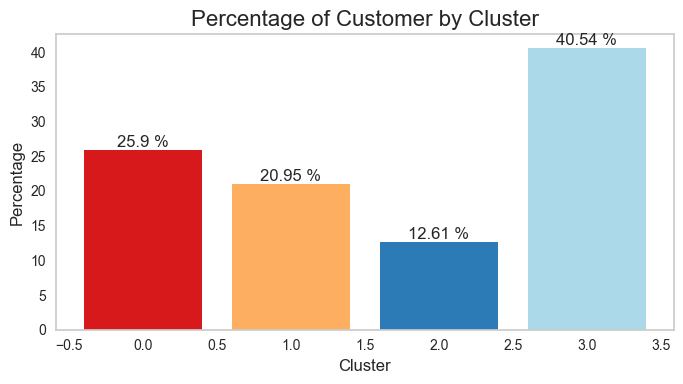

In [66]:
# visualization of the percentage of customers in each cluster
fig, ax = plt.subplots(figsize = (7,4))

c = ["#d7191c","#fdae61","#2c7bb6","#abd9e9", "#ffffbf"]

bars = plt.bar(x = cluster_count['cluster'],
               height = cluster_count['percentage (%)'],
               color = c)

for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s = f'{height} %', ha='center',
  va = 'bottom')

plt.title('Percentage of Customer by Cluster', fontsize = 16)
plt.xlabel('Cluster',fontsize = 12)
plt.ylabel('Percentage',fontsize = 12)
plt.style.use('tableau-colorblind10')
plt.grid(False)
plt.tight_layout()

In [67]:
# Hitung agregasi
agg_result = df_cluster.groupby('cluster').agg(['min', 'max', 'mean'])

# Bulatkan hasil agregasi menjadi dua angka desimal
agg_result = agg_result.round(2)

# Reset indeks dan tampilkan hasilnya
agg_result.reset_index(drop=True).T

0          1          2          3
TransactionID min       10.00       3.00      13.00       7.00
              max       16.00      10.00      21.00      14.00
              mean      13.29       7.02      16.39      10.43
Qty           min       37.00      10.00      50.00      26.00
              max       62.00      34.00      79.00      47.00
              mean      49.12      24.51      62.04      37.35
TotalAmount   min   318600.00   92100.00  448900.00  215100.00
              max   574000.00  319200.00  846700.00  440200.00
              mean  437241.74  208283.87  576716.07  325663.33

In [68]:
# Menghitung mean dan count untuk setiap cluster
df_cluster_mean = df_cluster.groupby('cluster').agg({
    'TransactionID': 'mean',  # Menghitung jumlah observasi dalam setiap cluster
    'Qty': 'mean',  # Menghitung rata-rata Qty dalam setiap cluster
    'TotalAmount': 'mean'  # Menghitung rata-rata TotalAmount dalam setiap cluster
}).reset_index()  # Mereset indeks sehingga cluster menjadi kolom biasa

# Menambahkan kolom 'Count' berisi jumlah penghitungan setiap cluster
df_cluster_mean['Count'] = df_cluster['cluster'].value_counts().values

# Mengganti nama kolom "Count" menjadi "Total_Customer"
df_cluster_mean = df_cluster_mean.rename(columns={'Count': 'TotalCustomer'})

# Menyortir DataFrame berdasarkan jumlah penghitungan (Count) dalam urutan menurun
df_cluster_mean = df_cluster_mean.sort_values(['TotalAmount', 'TransactionID', 'Qty'], ascending=False)

df_cluster_mean = df_cluster_mean.round(2)

In [69]:
df_cluster_mean.reset_index(drop=True)

,cluster,TransactionID,Qty,TotalAmount,TotalCustomer
0,2,16.39,62.04,576716.07,93
1,0,13.29,49.12,437241.74,180
2,3,10.43,37.35,325663.33,56
3,1,7.02,24.51,208283.87,115


## Clustering Interpretation
### 1. Cluster 0 - Loyal Customer
- Terdapat 180 Customer
- Pelanggan dikelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah total belanja yang tinggi yaitu dengan rata-rata transaksi sebesar 13 kali transaksi, rata-rata jumlah atau kuantitas produk yang dibeli sekitar 49 unit produk, dan rata-rata jumlah uang yang dikeluarkan oleh pelanggan sebesar 437k

### 2. Cluster 1 - New Customer
- Terdapat 115 customer
- Customer di kelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah dan total belanja paling rendah, rata-rata transaksi sekitar 7 kali transaksi, rata-rata jumlah atau kuantitas produk yang dibeli sekitar 24 unit produk, dan rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 208K

### 3. Cluster 3 - Regular Customer
- Terdapat 56 customer
- Customer di kelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah dan total belanja yang stabil dan sedang, yaitu rata-rata transaksi sekitar 10 kali transaksi, rata-rata jumlah atau kuantitas produk yang dibeli sekitar 37 unit produk, dan rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 325K

### 4. Cluster 2 - VIP Customer
- Terdapat 93 Customer
- Customer di kelompok ini adalah pelanggan yang melakukan transaksi yang tinggi dengan jumlah belanja yang besar, dan total belanja yang tinggi, yaitu: rata-rata transaksi sekitar 16 kali transaksi, rata-rata jumlah atau kuantitas produk yang dibeli sekitar 62 unit produk, dan rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 576K.